Starting


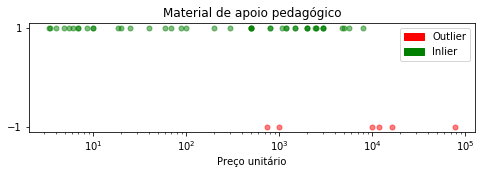

/home/mandala/virtualenvs/ml/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)


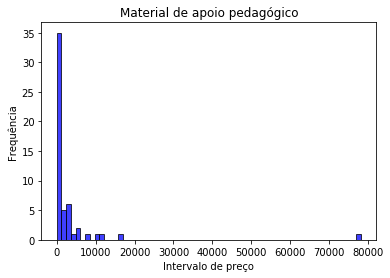

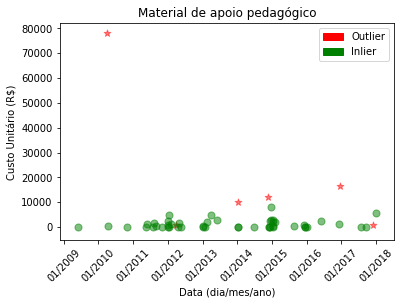

suspect = 750.0
outlier? = False


In [4]:
# %load find_outliers.py
from utils.csver import CSVer
from utils.plotter import Plotter

from IPython.display import display
from sklearn.neighbors import LocalOutlierFactor

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import matplotlib.patches as mpatches

pd.options.mode.chained_assignment = None

class FindOutliers:

    def __init__(self, training_data):
        self.training_data = training_data

    def train_1d(self):
        self.lof = LocalOutlierFactor()
      
        data_1d = self.training_data.reshape(-1, 1)
        self.lof_labels = self.lof.fit_predict(data_1d)
        return self.lof_labels
    
    def train(self):
        if self.is_data_1d():
            return self.train_1d()
        self.lof = LocalOutlierFactor()
    
    def is_data_1d(self):
        dimension = self.training_data.ndim
        return dimension == 1
    
    def plot_inliers_outliers_1d(self, item, data, labels):
        inliers = data[labels == 1]
        outliers = data[labels == -1]
        
        plt.figure(figsize=(8, 2))
        y1 = np.empty(len(inliers))
        y1.fill(1)
        
        y2 = np.empty(len(outliers))
        y2.fill(-1)
        
        plt.plot(inliers, y1, 'g.', markersize = 10, alpha = 0.50)
        plt.plot(outliers, y2, 'r.', markersize = 10, alpha = 0.50)
        plt.xscale('log')
        plt.xlabel('Preço unitário')
        red_patch = mpatches.Patch(color='red', label='Outlier')
        green_patch = mpatches.Patch(color='green', label='Inlier')
        plt.legend(handles=[red_patch, green_patch])
        plt.title(item)
        plt.yticks([-1, 1])
        plt.show()
        
    def get_xy(self, data, price_column):
        return (data['Data'].values,
                data[price_column].values)
    
    def find_outliers_by_price_only(self, prices):
        find_outliers = FindOutliers(prices)
        pred = find_outliers.train()
        return (prices, pred)
    
    def find_outliers_price_data(self, data, price_column):
        xy = data[['Data', price_column]]
        xy['Data'] = CSVer.get_date_axis_from_array(None, xy.Data)
        
        lof = LocalOutlierFactor()
        labels = lof.fit_predict(xy)
        return (xy, labels)
    
    def plot_outliers_along_time(self, item, data, labels, price_column):

        inliers = data[labels == 1]
        x1 = np.array(inliers['Data'].values)
        x1 = csver.get_date_axis_from_array(x1)
        y1 = np.array(inliers[price_column].values)
    
        outliers = data[labels == -1]
        x2 = np.array(outliers['Data'].values)
        x2 = csver.get_date_axis_from_array(x2)
        y2 = np.array(outliers[price_column].values)
        
        fig = plt.figure() 
        red_patch = mpatches.Patch(color='red', label='Outlier')
        green_patch = mpatches.Patch(color='green', label='Inlier')
        plt.legend(handles=[red_patch, green_patch])
    
        
        Plotter.plot_scatter_along_time(x2, y2, 'red', marker = '*', figure = fig)
        Plotter.plot_scatter_along_time(x1, y1, 'green', 'Data (dia/mes/ano)',
                                        'Custo Unitário (R$)', item, figure=fig)
        Plotter.show()
        
    def get_inlier_interval(self, inliers):
        return (inliers.min(), inliers.max())
    
    def is_outlier(self, inliers, suspect):
        amin, amax = self.get_inlier_interval(inliers)
        return suspect < amin or suspect > amax

#warnings.warn(message, mplDeprecation, stacklevel=1)
small_data = ['data/valor_unitario_aprovado_sample.csv']
csver = CSVer(small_data)

print('Starting')

%matplotlib inline

while True:
    
    item = csver.get_random_item('Item')
    rows = csver.filter_column_by_value('Item', item)
    if len(rows) < 25:
        continue
    
    fo = FindOutliers(rows)
    rows = csver.filter_column_by_value('Item', item)
    prices = rows['ValorUnitarioAprovado'].values
    
    data, labels = fo.find_outliers_by_price_only(prices)
    fo.plot_inliers_outliers_1d(item, data, labels)
    
    Plotter.plot_histogram(prices, 'Intervalo de preço', 'Frequência', item)
    
    fo.plot_outliers_along_time(item, rows, labels, 'ValorUnitarioAprovado')
    
    suspect = np.random.choice(prices)
    print('suspect = {}'.format(suspect))
    print('outlier? = {}'.format(fo.is_outlier(prices[labels == 1], suspect)))
    break